In [17]:
import pickle
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [7]:
# Constants
data_dir = 'C:/Users/admin/Downloads/cifar-10-python/cifar-10-batches-py'

# Load CIFAR-10 data
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10(data_dir):
    train_data, train_labels = [], []
    for i in range(1, 6):
        batch = unpickle(f'{data_dir}/data_batch_{i}')
        data = batch[b'data']
        labels = batch[b'labels']
        train_data.append(data)
        train_labels.extend(labels)

    test_batch = unpickle(f'{data_dir}/test_batch')
    test_data = test_batch[b'data']
    test_labels = test_batch[b'labels']

    train_data = np.concatenate(train_data)
    train_labels = np.array(train_labels)
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)

    return (train_data, train_labels), (test_data, test_labels)

def reshape_data(data):
    return data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

(train_data, train_labels), (test_data, test_labels) = load_cifar10(data_dir)
train_data, test_data = reshape_data(train_data), reshape_data(test_data)

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Convert images to uint8
def convert_to_uint8(image):
    image = np.clip(image, 0, 255)
    return image.astype(np.uint8)

# Extract SIFT features
def extract_sift_features(images):
    sift = cv2.SIFT_create()
    descriptors_list = []
    valid_indices = []

    start_time = time.time()  # Start timing

    for idx, img in enumerate(images):
        img = convert_to_uint8(img)
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        keypoints, descriptors = sift.detectAndCompute(img_gray, None)
        if descriptors is not None and len(descriptors) > 0:
            descriptors_list.append(descriptors)
            valid_indices.append(idx)

    end_time = time.time()  # End timing
    print(f"SIFT feature extraction time: {end_time - start_time} seconds")

    return descriptors_list, valid_indices

train_descriptors_list, train_valid_indices = extract_sift_features(train_data)
test_descriptors_list, test_valid_indices = extract_sift_features(test_data)

Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)
SIFT feature extraction time: 55.86997842788696 seconds
SIFT feature extraction time: 11.324226379394531 seconds


In [8]:
# Flatten the list of descriptors for k-means clustering
all_descriptors = np.vstack(train_descriptors_list + test_descriptors_list)

# Perform k-means clustering to create the visual words
num_clusters = 100 
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(all_descriptors)

# Save the visual word vocabulary
vocabulary = kmeans.cluster_centers_

# Create BoW histograms
def create_bow_histograms(descriptors_list, kmeans):
    histograms = []
    for descriptors in descriptors_list:
        words = kmeans.predict(descriptors)
        histogram, _ = np.histogram(words, bins=np.arange(kmeans.n_clusters + 1), density=True)
        histograms.append(histogram)
    return np.array(histograms)

train_bow_histograms = create_bow_histograms(train_descriptors_list, kmeans)
test_bow_histograms = create_bow_histograms(test_descriptors_list, kmeans)

# Normalize the histograms
scaler = StandardScaler()
train_bow_histograms = scaler.fit_transform(train_bow_histograms)
test_bow_histograms = scaler.transform(test_bow_histograms)

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [9]:
# Train an SVM classifier
svm = SVC(kernel='linear', random_state=0)
svm.fit(train_bow_histograms, train_labels[train_valid_indices])

# Predict and evaluate on test data
test_predictions = svm.predict(test_bow_histograms)
print("BoW SVM Classification Report:")
print(classification_report(test_labels[test_valid_indices], test_predictions))

print("Confusion Matrix:")
print(confusion_matrix(test_labels[test_valid_indices], test_predictions))

BoW SVM Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.37      0.35       993
           1       0.29      0.31      0.30      1000
           2       0.20      0.13      0.16       998
           3       0.19      0.14      0.16       999
           4       0.18      0.16      0.17       999
           5       0.24      0.28      0.26      1000
           6       0.22      0.24      0.23      1000
           7       0.26      0.27      0.26      1000
           8       0.30      0.31      0.31       997
           9       0.28      0.32      0.30      1000

    accuracy                           0.25      9986
   macro avg       0.25      0.25      0.25      9986
weighted avg       0.25      0.25      0.25      9986

Confusion Matrix:
[[367  81  85  28  66  37  33  92 145  59]
 [ 80 311  36  48  50  77 100  52 122 124]
 [173  79 127  65 106 100 105 101  80  62]
 [ 57  73  53 139  92 171 120 111  60 123]
 [ 75  77  69  73 16

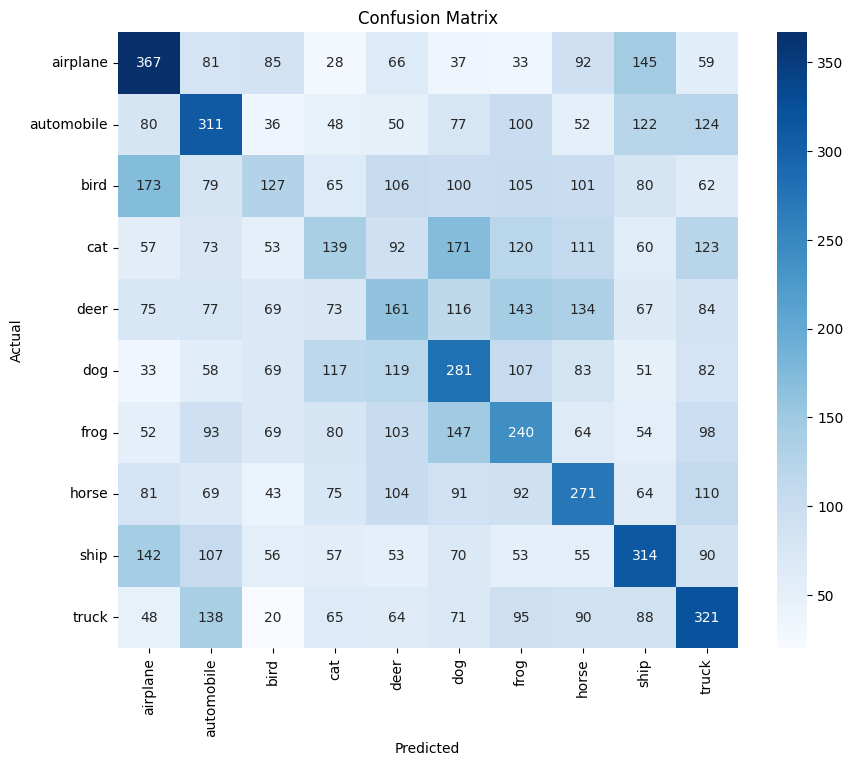

In [19]:
# Plot confusion matrix
cm = confusion_matrix(test_labels[test_valid_indices], test_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cifar10_labels, yticklabels=cifar10_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

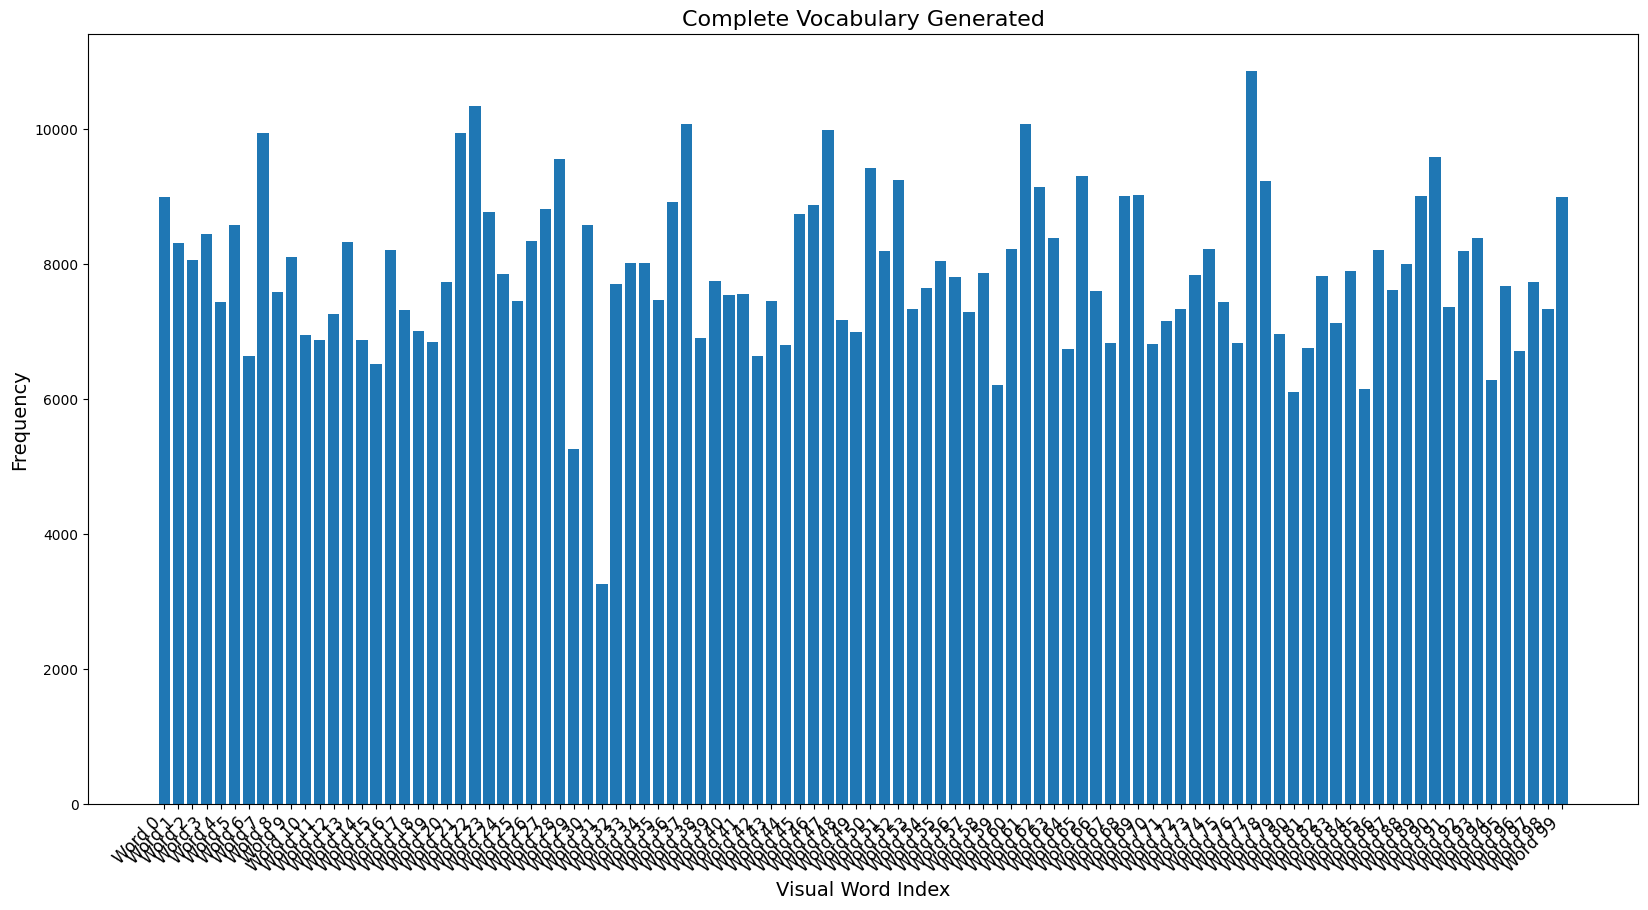

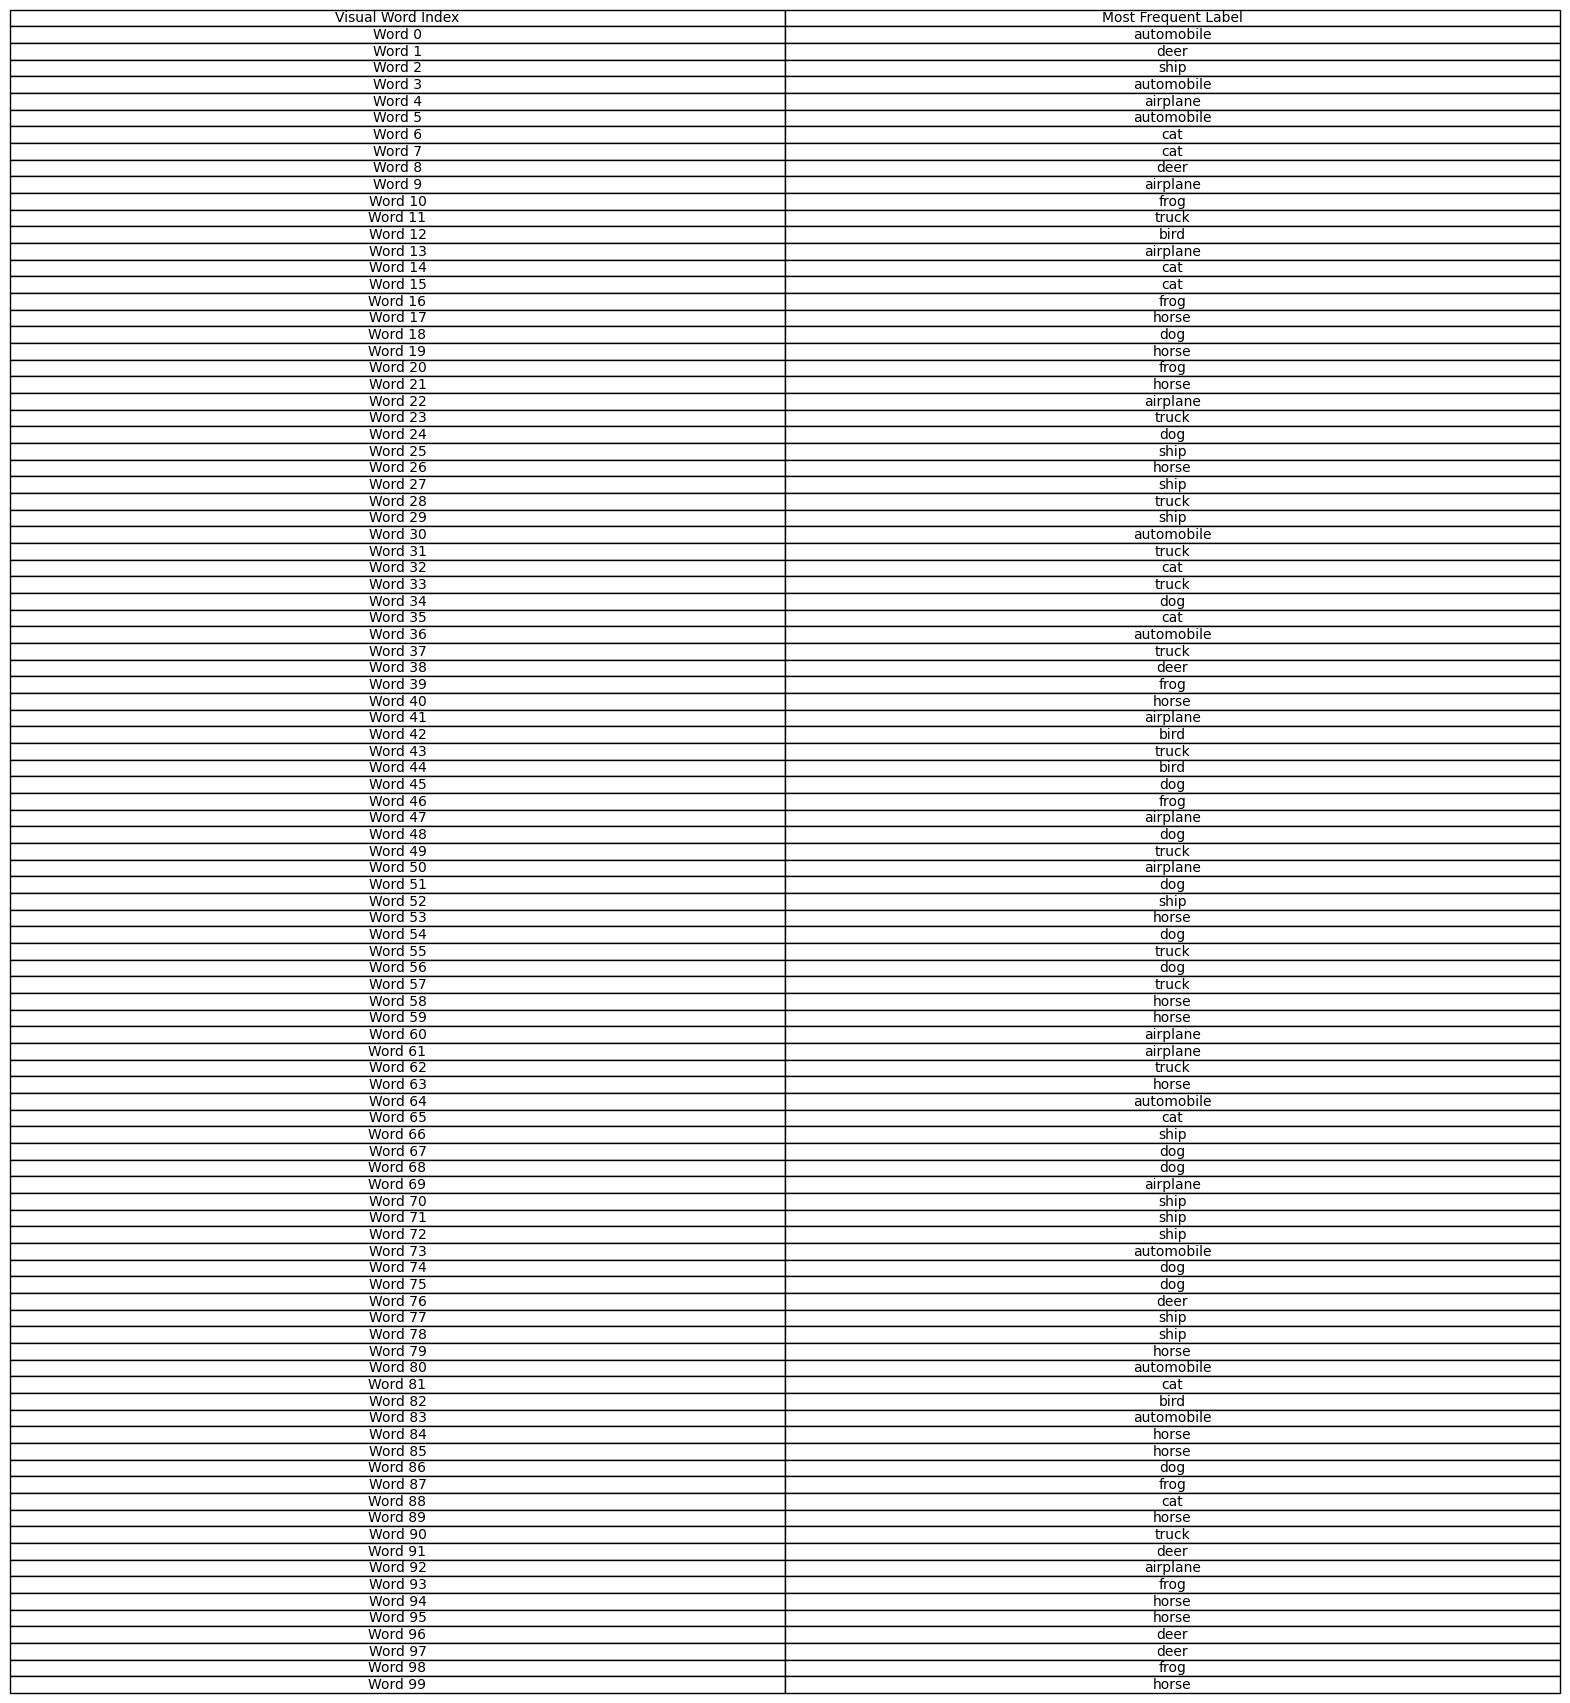

In [10]:
# CIFAR-10 labels
cifar10_labels = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Count the most frequent class labels for each visual word
visual_word_labels = {i: [] for i in range(num_clusters)}

for i, descriptors in enumerate(train_descriptors_list):
    words = kmeans.predict(descriptors)
    most_frequent_word = np.argmax(np.bincount(words))
    visual_word_labels[most_frequent_word].append(train_labels[train_valid_indices[i]])

# Find the most frequent class label for each visual word
visual_word_class_labels = {}
for word, labels in visual_word_labels.items():
    if labels:
        most_common_label = Counter(labels).most_common(1)[0][0]
        visual_word_class_labels[word] = cifar10_labels[most_common_label]
    else:
        visual_word_class_labels[word] = 'Unknown'

# Visualize the frequency of visual words with their labels
word_counts = np.bincount(kmeans.labels_)
visual_word_labels = [f'Word {i}' for i in range(num_clusters)]

# Adjust figure size for the plot
fig, ax = plt.subplots(figsize=(20, 10))
bars = ax.bar(range(num_clusters), word_counts)
ax.set_xlabel('Visual Word Index', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Complete Vocabulary Generated', fontsize=16)

# Keep x-axis labels simple
ax.set_xticks(range(num_clusters))
ax.set_xticklabels(visual_word_labels, rotation=45, ha='right', fontsize=12)

# Prepare the index/legend in a separate table
index_table = [[f'Word {i}', visual_word_class_labels[i]] for i in range(num_clusters)]

# Create a new figure for the index table
fig2, ax2 = plt.subplots(figsize=(20, 10))
ax2.axis('tight')
ax2.axis('off')
table = ax2.table(cellText=index_table, colLabels=['Visual Word Index', 'Most Frequent Label'], cellLoc='center', loc='center')

# Display both plots
plt.show()

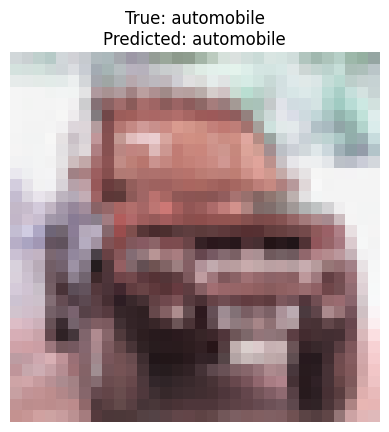

In [16]:
# Display an image by index and its predicted class
def display_image_and_prediction_by_index(data, labels, valid_indices, index, classifier, kmeans, scaler):
    if index not in valid_indices:
        print(f"Index {index} is not valid.")
        return

    img = data[index]
    label = labels[index]

    img = convert_to_uint8(img)
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img_gray, None)

    if descriptors is not None and len(descriptors) > 0:
        words = kmeans.predict(descriptors)
        histogram, _ = np.histogram(words, bins=np.arange(kmeans.n_clusters + 1), density=True)
        histogram = scaler.transform([histogram])
        prediction = classifier.predict(histogram)[0]

        plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        plt.title(f"True: {cifar10_labels[label]}\nPredicted: {cifar10_labels[prediction]}")
        plt.axis('off')
        plt.show()

display_image_and_prediction_by_index(test_data, test_labels, test_valid_indices, 9, svm, kmeans, scaler)